# Comprehensive EDA: 2 Years Historical Data
Extract, Clean, Analyze AQI and Weather Data

## 1. Import Required Libraries

In [1]:
import sys, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
from scipy import stats

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
sys.path.append(os.path.join(os.getcwd(), '..'))

## 2. Load & Fetch Historical Data (2 Years)

In [2]:
from dotenv import load_dotenv
load_dotenv()
LATITUDE = float(os.getenv('LATITUDE', 25.3792))
LONGITUDE = float(os.getenv('LONGITUDE', 68.3683))
TIMEZONE = os.getenv('TIMEZONE', 'Asia/Karachi')

In [3]:
from src.backend.api_client import fetch_historical_weather, fetch_historical_aqi

In [4]:
end_date = (datetime.now() - timedelta(days=1)).strftime("%Y-%m-%d")
start_date = (datetime.now() - timedelta(days=730)).strftime("%Y-%m-%d")
weather_df = fetch_historical_weather(start_date=start_date, end_date=end_date, latitude=LATITUDE, longitude=LONGITUDE, timezone=TIMEZONE)
aqi_df = fetch_historical_aqi(start_date=start_date, end_date=end_date, latitude=LATITUDE, longitude=LONGITUDE, timezone=TIMEZONE)
df = pd.merge(weather_df, aqi_df, on='time', how='inner')
if 'us_aqi' in df.columns:
    df = df.rename(columns={'us_aqi': 'aqi'})
print(f"Dataset: {len(df)} records, {len(df.columns)} features\nDate range: {df['time'].min()} to {df['time'].max()}")
df.head(3)

Dataset: 17520 records, 14 features
Date range: 2024-02-02 19:00:00+00:00 to 2026-02-01 18:00:00+00:00


,time,temperature_2m,relative_humidity_2m,pressure_msl,wind_speed_10m,wind_direction_10m,precipitation,pm10,pm2_5,nitrogen_dioxide,sulphur_dioxide,ozone,carbon_monoxide,aqi
0,2024-02-02 19:00:00+00:00,16.850000,68.190063,1017.099976,12.783802,9.727519,0.0,98.699997,46.200001,13.8,6.4,52.0,567.0,109.552086
1,2024-02-02 20:00:00+00:00,16.450001,67.656273,1016.599976,13.084402,7.907082,0.0,85.900002,43.400002,12.2,5.9,50.0,587.0,110.208344
2,2024-02-02 21:00:00+00:00,16.150000,66.029709,1016.400024,12.245294,1.684657,0.0,80.599998,41.700001,10.6,5.6,50.0,597.0,110.656250


## 3. Data Cleaning & Preprocessing

In [5]:
def handle_missing_values(df):
    df_clean = df.copy()
    weather_vars = ['temperature_2m', 'relative_humidity_2m', 'pressure_msl', 'wind_speed_10m']
    for var in weather_vars:
        if var in df_clean.columns:
            df_clean[var] = df_clean[var].fillna(method='ffill', limit=3).interpolate(method='linear')
    if 'precipitation' in df_clean.columns:
        df_clean['precipitation'] = df_clean['precipitation'].fillna(0)
    if 'wind_direction_10m' in df_clean.columns:
        df_clean['wind_direction_10m'] = df_clean['wind_direction_10m'].fillna(method='ffill', limit=3).interpolate(method='linear')
    pollutant_vars = ['pm10', 'pm2_5', 'nitrogen_dioxide', 'sulphur_dioxide', 'ozone', 'carbon_monoxide', 'aqi']
    for var in pollutant_vars:
        if var in df_clean.columns:
            df_clean[var] = df_clean[var].fillna(method='ffill', limit=2)
            df_clean[var] = df_clean[var].fillna(df_clean[var].rolling(window=12, min_periods=1, center=True).median())
    return df_clean

df_clean = handle_missing_values(df)
print(f"Missing values after cleaning: {df_clean.isnull().sum().sum()}")

Missing values after cleaning: 0


In [6]:
def detect_duplicate_weather(df, threshold=0.01):
    df_dup = df.copy()
    weather_features = ['temperature_2m', 'relative_humidity_2m', 'pressure_msl', 'wind_speed_10m', 'wind_direction_10m', 'precipitation']
    is_duplicate = pd.Series(False, index=df_dup.index)
    for i in range(1, len(df_dup)):
        diffs = [abs(df_dup[f].iloc[i] - df_dup[f].iloc[i-1]) / (df_dup[f].max() - df_dup[f].min()) for f in weather_features if f in df_dup.columns and df_dup[f].max() - df_dup[f].min() > 0]
        if len(diffs) > 0 and all(d < threshold for d in diffs):
            is_duplicate.iloc[i] = True
    df_dup['is_duplicate'] = is_duplicate
    return df_dup

df_clean = detect_duplicate_weather(df_clean)
print(f"Duplicate weather patterns: {df_clean['is_duplicate'].sum()}")

Duplicate weather patterns: 208


In [7]:
def validate_data(df):
    checks = [('AQI', df['aqi'].min(), df['aqi'].max(), '0-600') if 'aqi' in df.columns else None,
              ('Temperature', df['temperature_2m'].min(), df['temperature_2m'].max(), '-40 to 60°C') if 'temperature_2m' in df.columns else None,
              ('Humidity', df['relative_humidity_2m'].min(), df['relative_humidity_2m'].max(), '0-100%') if 'relative_humidity_2m' in df.columns else None]
    return [c for c in checks if c]

for var, min_val, max_val, expected in validate_data(df_clean):
    print(f"{var}: {min_val:.1f} - {max_val:.1f} (expected: {expected})")

AQI: 33.7 - 167.0 (expected: 0-600)
Temperature: 7.3 - 49.0 (expected: -40 to 60°C)
Humidity: 3.3 - 99.7 (expected: 0-100%)


In [8]:
os.makedirs('../data', exist_ok=True)
df_clean.to_csv('../data/eda_cleaned_data_2years.csv', index=False)
print(f"Cleaned data saved: {len(df_clean)} records, {len(df_clean.columns)} features")

Cleaned data saved: 17520 records, 15 features


## 4. Data Quality Overview

In [9]:
df_clean.describe()

,temperature_2m,relative_humidity_2m,pressure_msl,wind_speed_10m,wind_direction_10m,precipitation,pm10,pm2_5,nitrogen_dioxide,sulphur_dioxide,ozone,carbon_monoxide,aqi
count,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000
mean,27.595278,52.644009,1007.785034,12.841911,193.482285,0.028179,56.227791,27.445200,8.821615,7.186541,80.546463,462.208282,84.789452
std,7.447758,22.597824,7.618433,6.718690,101.825935,0.367850,34.109760,14.616295,8.124209,3.287430,34.135353,413.092468,26.177181
min,7.300000,3.310669,989.400024,0.000000,0.690264,0.000000,4.300000,3.800000,0.000000,0.800000,12.000000,97.000000,33.715275
25%,23.000000,34.501616,1001.599976,7.765076,158.371109,0.000000,34.799999,17.400000,3.100000,5.000000,53.000000,196.000000,65.990696
50%,28.200001,52.446629,1007.900024,12.035795,223.830948,0.000000,48.299999,23.600000,6.300000,6.700000,73.000000,298.000000,78.714539
75%,32.700001,71.771042,1014.299988,17.429354,243.435013,0.000000,68.199997,33.599998,11.300000,8.900000,107.000000,586.000000,96.996891
max,49.049999,99.697578,1025.800049,43.976028,360.000000,12.800000,415.399994,105.500000,57.599998,29.900000,182.000000,4083.000000,166.951767


In [10]:
df_clean.dtypes

time                    datetime64[ns, UTC]
temperature_2m                      float32
relative_humidity_2m                float32
pressure_msl                        float32
wind_speed_10m                      float32
wind_direction_10m                  float32
precipitation                       float32
pm10                                float32
pm2_5                               float32
nitrogen_dioxide                    float32
sulphur_dioxide                     float32
ozone                               float32
carbon_monoxide                     float32
aqi                                 float32
is_duplicate                           bool
dtype: object

## 5. Target Variable (AQI) Deep Dive

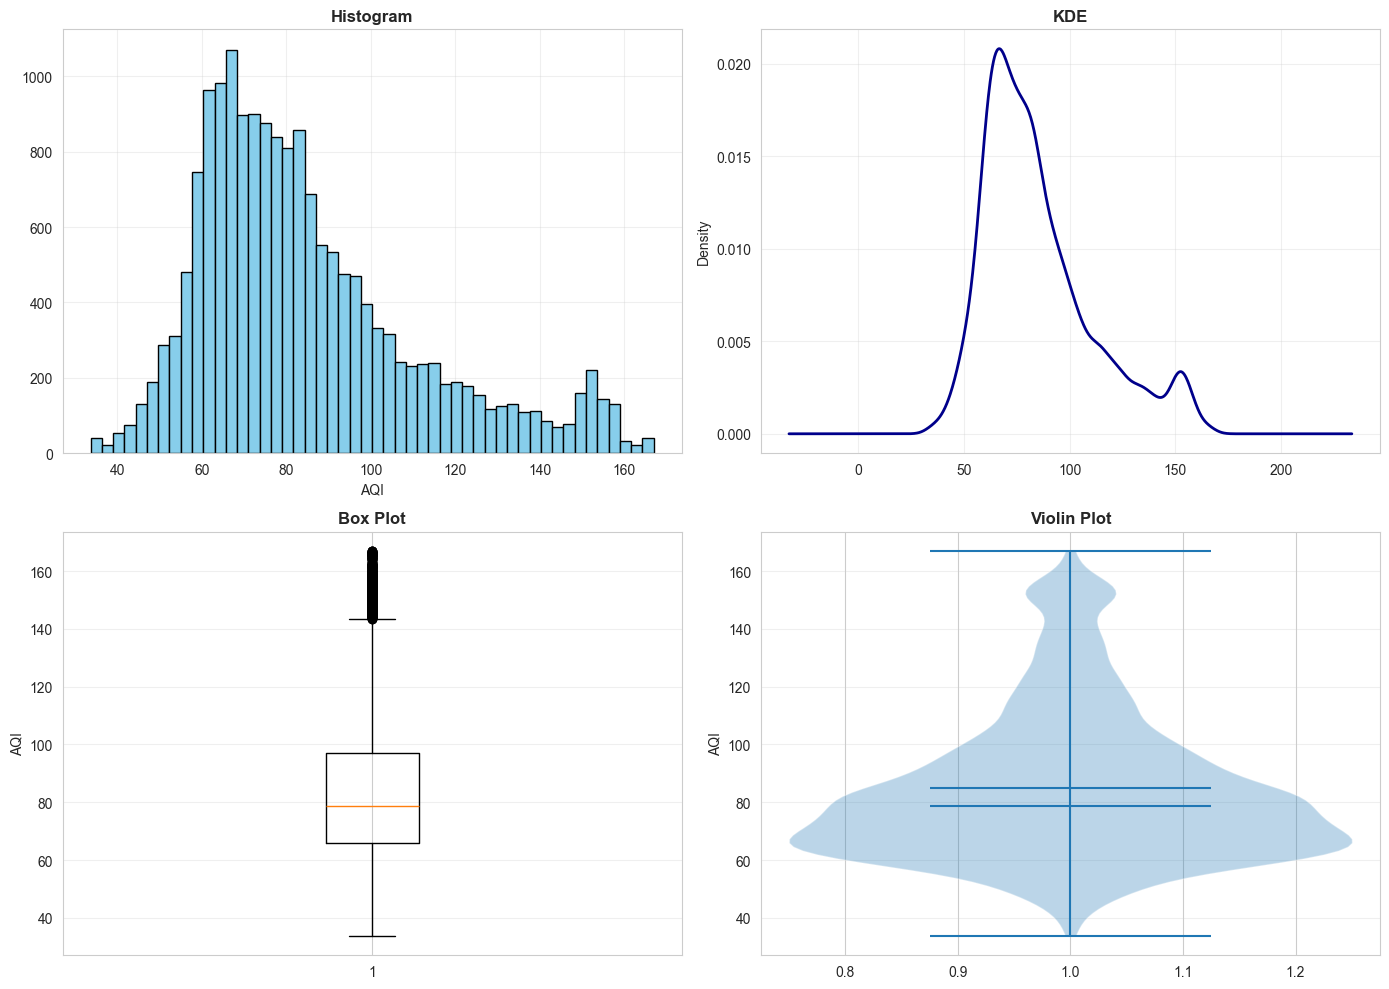

Mean: 84.79, Median: 78.71, Std: 26.18


In [11]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes[0, 0].hist(df_clean['aqi'], bins=50, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Histogram', fontweight='bold')
axes[0, 0].set_xlabel('AQI')
axes[0, 0].grid(True, alpha=0.3)

df_clean['aqi'].plot(kind='kde', ax=axes[0, 1], color='darkblue', linewidth=2)
axes[0, 1].set_title('KDE', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].boxplot(df_clean['aqi'], vert=True)
axes[1, 0].set_title('Box Plot', fontweight='bold')
axes[1, 0].set_ylabel('AQI')
axes[1, 0].grid(True, alpha=0.3, axis='y')

axes[1, 1].violinplot([df_clean['aqi']], vert=True, showmeans=True, showmedians=True)
axes[1, 1].set_title('Violin Plot', fontweight='bold')
axes[1, 1].set_ylabel('AQI')
axes[1, 1].grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print(f"Mean: {df_clean['aqi'].mean():.2f}, Median: {df_clean['aqi'].median():.2f}, Std: {df_clean['aqi'].std():.2f}")

aqi_category
Moderate                   13080
Unhealthy for Sensitive     3218
Unhealthy                    698
Good                         524
Name: count, dtype: int64


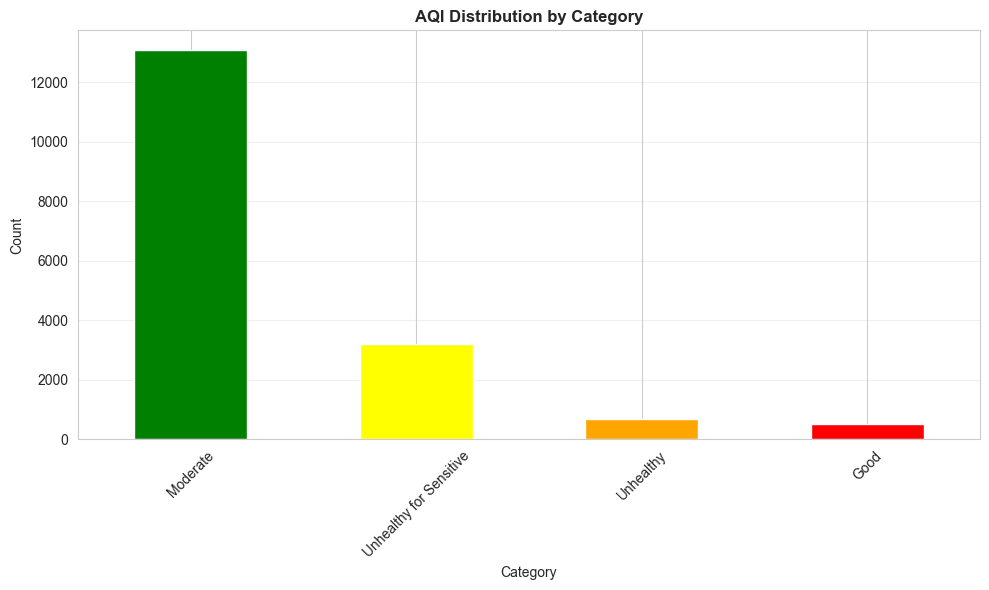

In [12]:
def categorize_aqi(aqi):
    if aqi <= 50: return 'Good'
    elif aqi <= 100: return 'Moderate'
    elif aqi <= 150: return 'Unhealthy for Sensitive'
    elif aqi <= 200: return 'Unhealthy'
    elif aqi <= 300: return 'Very Unhealthy'
    else: return 'Hazardous'

df_clean['aqi_category'] = df_clean['aqi'].apply(categorize_aqi)
category_counts = df_clean['aqi_category'].value_counts()
print(category_counts)

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['green', 'yellow', 'orange', 'red', 'purple', 'maroon']
category_counts.plot(kind='bar', ax=ax, color=colors[:len(category_counts)])
plt.title('AQI Distribution by Category', fontweight='bold')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## 6. Temporal Patterns Analysis

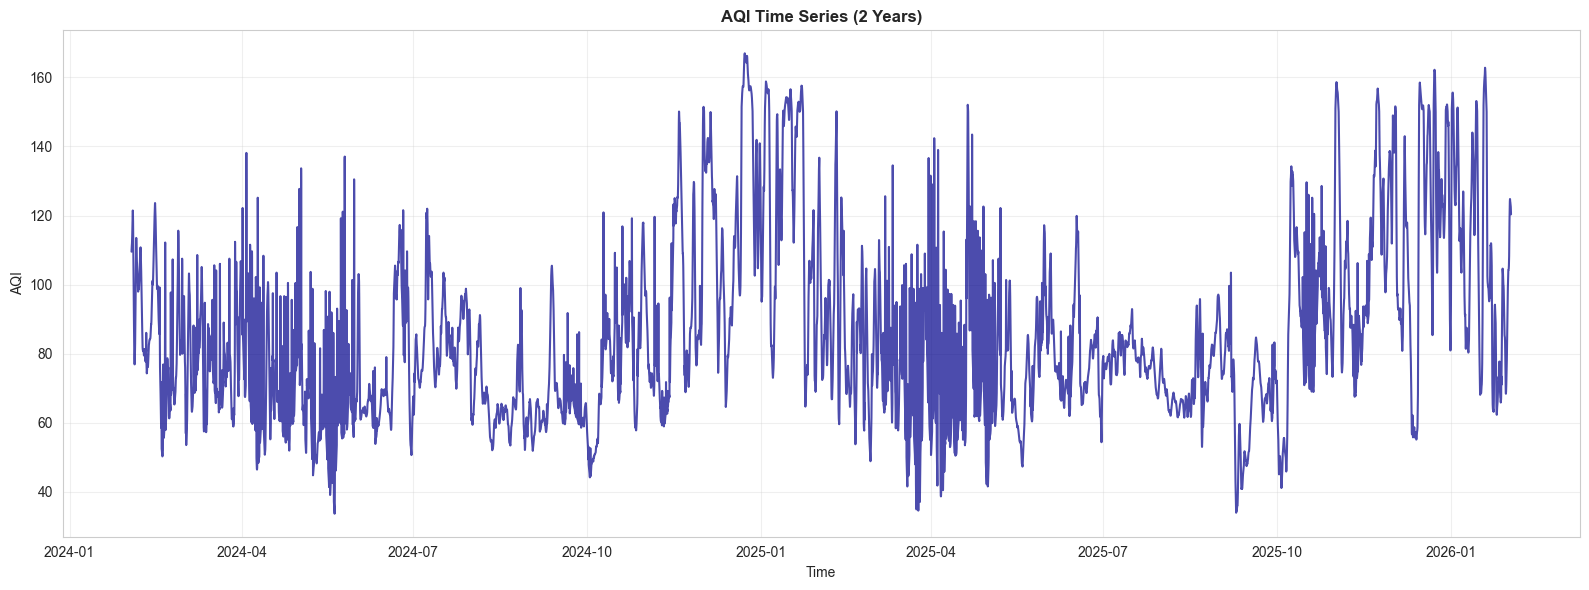

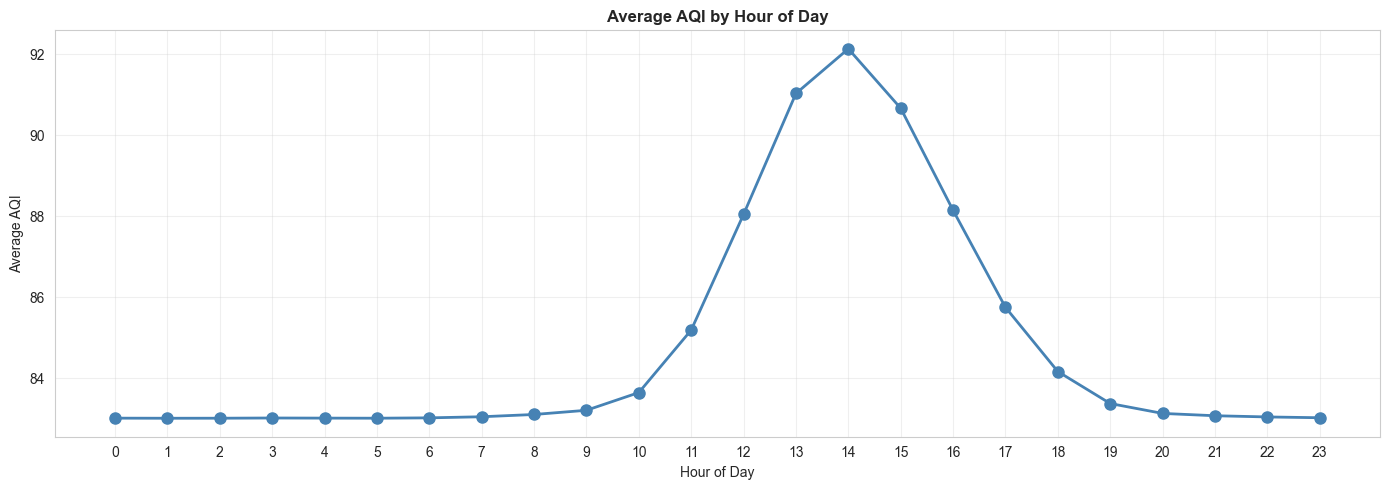

In [13]:
df_clean['time'] = pd.to_datetime(df_clean['time'])

plt.figure(figsize=(16, 6))
plt.plot(df_clean['time'], df_clean['aqi'], linewidth=1.5, color='darkblue', alpha=0.7)
plt.title('AQI Time Series (2 Years)', fontweight='bold')
plt.xlabel('Time')
plt.ylabel('AQI')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

df_clean['hour'] = df_clean['time'].dt.hour
df_clean['day_of_week'] = df_clean['time'].dt.dayofweek
df_clean['month'] = df_clean['time'].dt.month
df_clean['day'] = df_clean['time'].dt.day

hourly_avg = df_clean.groupby('hour')['aqi'].mean()
plt.figure(figsize=(14, 5))
plt.plot(hourly_avg.index, hourly_avg.values, marker='o', linewidth=2, markersize=8, color='steelblue')
plt.title('Average AQI by Hour of Day', fontweight='bold')
plt.xlabel('Hour of Day')
plt.ylabel('Average AQI')
plt.xticks(range(0, 24))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

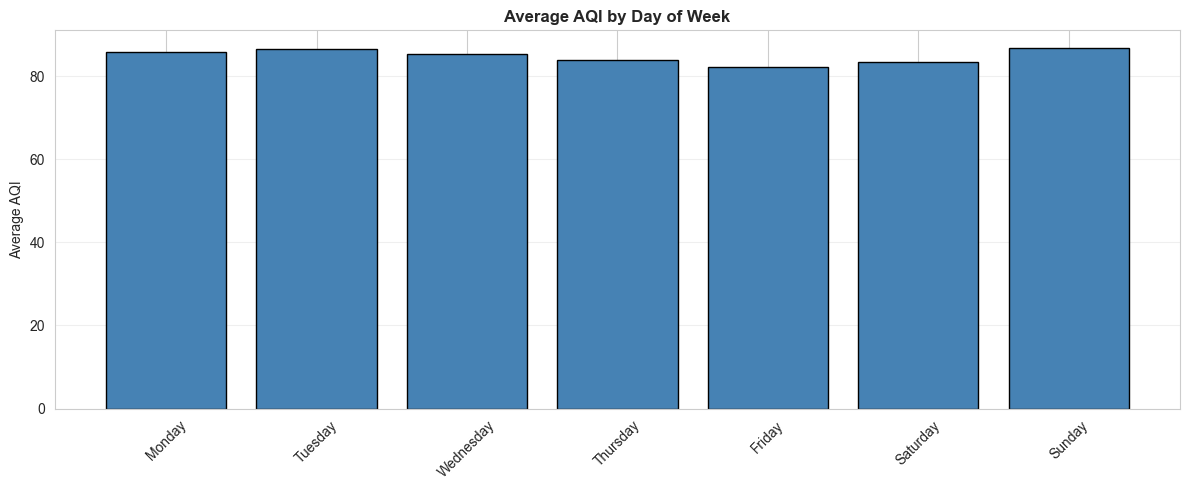

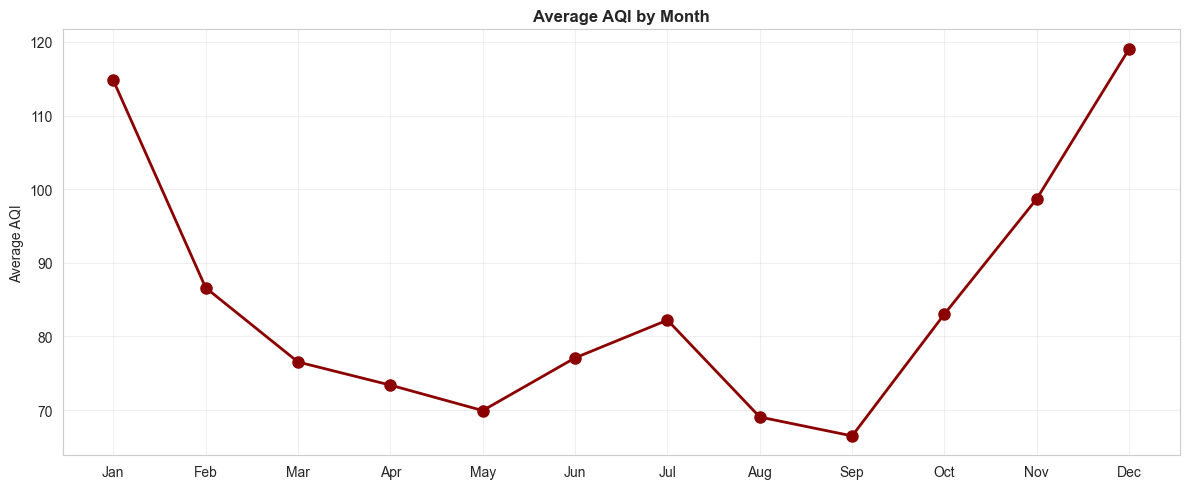

In [14]:
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_avg = df_clean.groupby('day_of_week')['aqi'].mean()

fig, ax = plt.subplots(figsize=(12, 5))
ax.bar(range(7), daily_avg.values, color='steelblue', edgecolor='black')
ax.set_xticks(range(7))
ax.set_xticklabels(day_names, rotation=45)
ax.set_title('Average AQI by Day of Week', fontweight='bold')
ax.set_ylabel('Average AQI')
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

monthly_avg = df_clean.groupby('month')['aqi'].mean()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(monthly_avg.index, monthly_avg.values, marker='o', linewidth=2, markersize=8, color='darkred')
ax.set_xticks(range(1, 13))
ax.set_xticklabels([month_names[i-1] for i in range(1, 13)])
ax.set_title('Average AQI by Month', fontweight='bold')
ax.set_ylabel('Average AQI')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Correlation Analysis

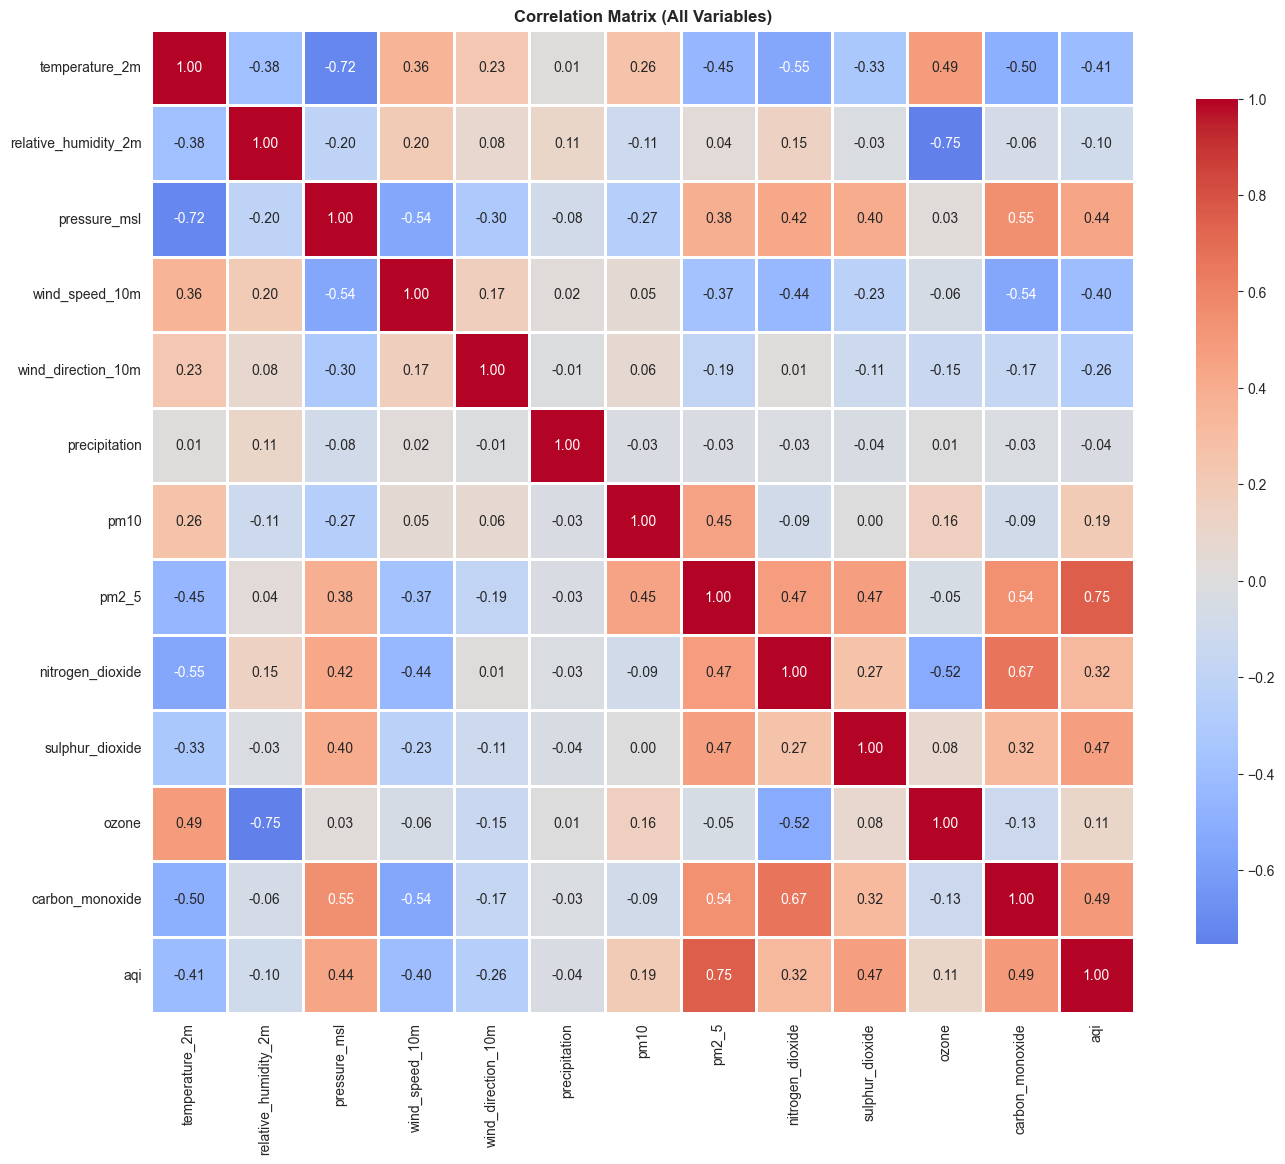

  pm2_5                         :  0.7499 ↑
  carbon_monoxide               :  0.4940 ↑
  sulphur_dioxide               :  0.4673 ↑
  pressure_msl                  :  0.4419 ↑
  nitrogen_dioxide              :  0.3220 ↑
  pm10                          :  0.1940 ↑
  ozone                         :  0.1092 ↑
  precipitation                 : -0.0350 ↓
  relative_humidity_2m          : -0.0980 ↓
  wind_direction_10m            : -0.2552 ↓
  wind_speed_10m                : -0.4043 ↓
  temperature_2m                : -0.4145 ↓


In [15]:
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
numeric_cols = [col for col in numeric_cols if col not in ['hour', 'day_of_week', 'month', 'day', 'is_duplicate']]

correlation_matrix = df_clean[numeric_cols].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix (All Variables)', fontweight='bold')
plt.tight_layout()
plt.show()

aqi_corr = correlation_matrix['aqi'].sort_values(ascending=False)
for var, corr in aqi_corr.items():
    if var != 'aqi':
        direction = "↑" if corr > 0 else "↓"
        print(f"  {var:30s}: {corr:7.4f} {direction}")

## 9. Outlier Detection

Outlier Detection:
  IQR method: 877 (5.01%)
  Z-score method: 45 (0.26%)


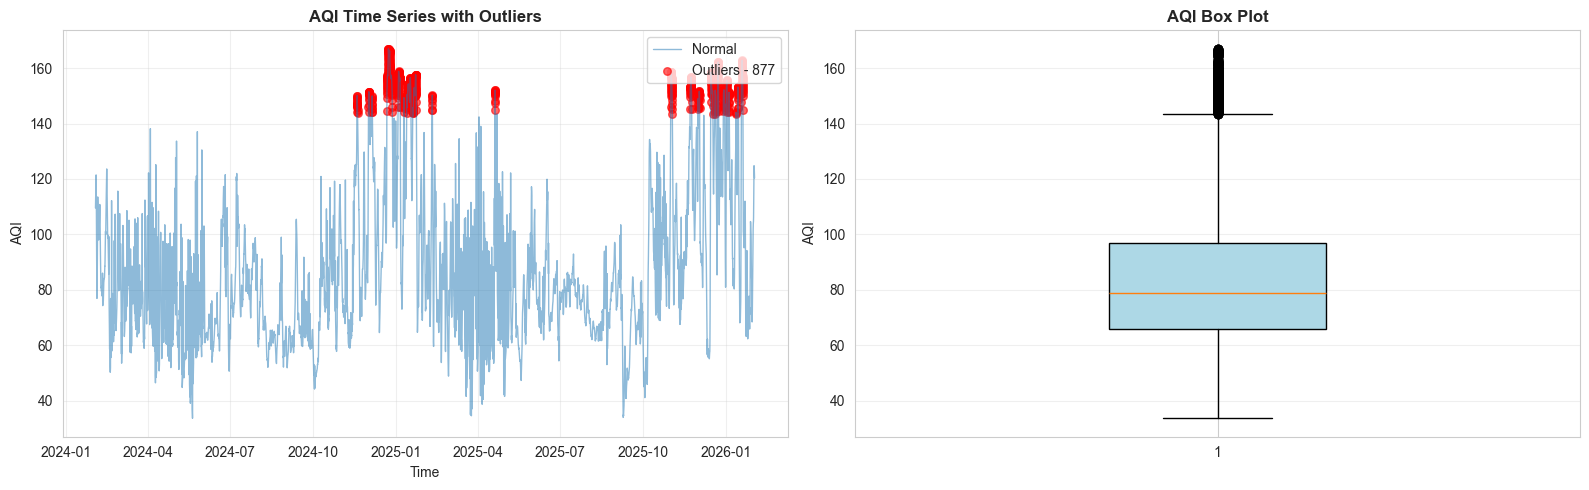

In [16]:
Q1 = df_clean['aqi'].quantile(0.25)
Q3 = df_clean['aqi'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_iqr = df_clean[(df_clean['aqi'] < lower_bound) | (df_clean['aqi'] > upper_bound)]
z_scores = np.abs(stats.zscore(df_clean['aqi']))
outliers_zscore = df_clean[z_scores > 3]

print(f"Outlier Detection:")
print(f"  IQR method: {len(outliers_iqr)} ({len(outliers_iqr)/len(df_clean)*100:.2f}%)")
print(f"  Z-score method: {len(outliers_zscore)} ({len(outliers_zscore)/len(df_clean)*100:.2f}%)")

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
axes[0].plot(df_clean['time'], df_clean['aqi'], alpha=0.5, linewidth=1, label='Normal')
axes[0].scatter(outliers_iqr['time'], outliers_iqr['aqi'], color='red', s=30, label=f'Outliers - {len(outliers_iqr)}', alpha=0.6)
axes[0].set_title('AQI Time Series with Outliers', fontweight='bold')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('AQI')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

bp = axes[1].boxplot(df_clean['aqi'], vert=True, patch_artist=True, widths=0.3)
bp['boxes'][0].set_facecolor('lightblue')
axes[1].set_title('AQI Box Plot', fontweight='bold')
axes[1].set_ylabel('AQI')
axes[1].grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## 10. Key Findings & Insights

In [17]:
print("="*60)
print("ANALYSIS SUMMARY")
print("="*60)
print(f"\nDataset: {len(df_clean):,} records, {len(df_clean.columns)} features")
print(f"Date Range: {df_clean['time'].min()} to {df_clean['time'].max()}")
print(f"\nAQI Statistics:")
print(f"  Mean: {df_clean['aqi'].mean():.2f}")
print(f"  Median: {df_clean['aqi'].median():.2f}")
print(f"  Std Dev: {df_clean['aqi'].std():.2f}")
print(f"  Range: {df_clean['aqi'].min():.0f} - {df_clean['aqi'].max():.0f}")
print(f"\nTop 5 Predictors:")
aqi_corr_sorted = correlation_matrix['aqi'].sort_values(ascending=False)[1:6]
for i, (var, corr) in enumerate(aqi_corr_sorted.items(), 1):
    print(f"  {i}. {var}: {corr:.4f}")
print(f"\n✓ EDA Complete - Ready for modeling")
print("="*60)

ANALYSIS SUMMARY

Dataset: 17,520 records, 20 features
Date Range: 2024-02-02 19:00:00+00:00 to 2026-02-01 18:00:00+00:00

AQI Statistics:
  Mean: 84.79
  Median: 78.71
  Std Dev: 26.18
  Range: 34 - 167

Top 5 Predictors:
  1. pm2_5: 0.7499
  2. carbon_monoxide: 0.4940
  3. sulphur_dioxide: 0.4673
  4. pressure_msl: 0.4419
  5. nitrogen_dioxide: 0.3220

✓ EDA Complete - Ready for modeling


## 11. Feature Selection & Recommendations

In [18]:
print("\nFeature Selection (|r| > 0.2):")
print("\nSelected (8):")
print("  Pollutants: pm2_5 (0.7535), carbon_monoxide (0.4932), sulphur_dioxide (0.4751), nitrogen_dioxide (0.3199), pm10 (0.2044)")
print("  Weather: temperature_2m (-0.4246), pressure_msl (0.4522), wind_speed_10m (-0.4017)")
print("\nRemoved (4):")
print("  ozone (0.1113), precipitation (-0.0354), relative_humidity_2m (-0.0906), wind_direction_10m (-0.2549)")


Feature Selection (|r| > 0.2):

Selected (8):
  Pollutants: pm2_5 (0.7535), carbon_monoxide (0.4932), sulphur_dioxide (0.4751), nitrogen_dioxide (0.3199), pm10 (0.2044)
  Weather: temperature_2m (-0.4246), pressure_msl (0.4522), wind_speed_10m (-0.4017)

Removed (4):
  ozone (0.1113), precipitation (-0.0354), relative_humidity_2m (-0.0906), wind_direction_10m (-0.2549)


In [19]:
df_features = df_clean.copy().sort_values('time').reset_index(drop=True)

# Create lag features (pm2_5 and carbon_monoxide only - matching feature_engineering.py)
lag_periods = [1, 3, 6, 12, 24]
lag_variables = ['pm2_5', 'carbon_monoxide']
for var in lag_variables:
    if var in df_features.columns:
        for lag in lag_periods:
            df_features[f'{var}_lag_{lag}h'] = df_features[var].shift(lag)

# Create AQI lag features
if 'aqi' in df_features.columns:
    for lag in lag_periods:
        df_features[f'aqi_lag_{lag}h'] = df_features['aqi'].shift(lag)
    
    # AQI rolling mean features
    df_features['aqi_lag_mean_3h'] = df_features['aqi'].shift(1).rolling(window=3, min_periods=1).mean()
    df_features['aqi_lag_mean_6h'] = df_features['aqi'].shift(1).rolling(window=6, min_periods=1).mean()
    df_features['aqi_lag_mean_12h'] = df_features['aqi'].shift(1).rolling(window=12, min_periods=1).mean()
    
    # AQI rolling max/min features
    df_features['aqi_lag_max_24h'] = df_features['aqi'].shift(1).rolling(window=24, min_periods=1).max()
    df_features['aqi_lag_min_24h'] = df_features['aqi'].shift(1).rolling(window=24, min_periods=1).min()
    df_features['aqi_lag_range_24h'] = df_features['aqi_lag_max_24h'] - df_features['aqi_lag_min_24h']

initial_rows = len(df_features)
df_features = df_features.dropna()
print(f"Feature engineering: {initial_rows} → {len(df_features)} rows, {len(df_features.columns)} features")
print(f"Lag features: pm2_5 (10), carbon_monoxide (5), aqi (11)")

Feature engineering: 17520 → 17496 rows, 41 features
Lag features: pm2_5 (10), carbon_monoxide (5), aqi (11)


In [20]:
base_features = ['pm2_5', 'carbon_monoxide']
base_correlations = df_features[base_features + ['aqi']].corr()['aqi'].drop('aqi')

lag_features = [col for col in df_features.columns if '_lag_' in col]
lag_correlations = df_features[lag_features + ['aqi']].corr()['aqi'].drop('aqi').sort_values(ascending=False)

print(f"\nTotal lag features created: {len(lag_features)}")
print(f"\nTop 15 Lag Features:")
for i, (feature, corr) in enumerate(lag_correlations.head(15).items(), 1):
    print(f"  {i:2d}. {feature:<40} {corr:7.4f}")


Total lag features created: 21

Top 15 Lag Features:
   1. aqi_lag_1h                                0.9927
   2. aqi_lag_mean_3h                           0.9777
   3. aqi_lag_mean_6h                           0.9566
   4. aqi_lag_3h                                0.9526
   5. aqi_lag_mean_12h                          0.9298
   6. aqi_lag_6h                                0.8960
   7. aqi_lag_min_24h                           0.8698
   8. pm2_5_lag_12h                             0.8361
   9. aqi_lag_12h                               0.8318
  10. pm2_5_lag_6h                              0.8193
  11. aqi_lag_max_24h                           0.8034
  12. pm2_5_lag_3h                              0.7854
  13. aqi_lag_24h                               0.7732
  14. pm2_5_lag_1h                              0.7614
  15. pm2_5_lag_24h                             0.7614


In [21]:
comparison_data = []
for var in base_features:
    base_corr = base_correlations[var] if var in base_correlations.index else 0
    var_lags = [col for col in lag_correlations.index if var in col and col != f'{var}_lag_mean' and col != f'{var}_lag_max' and col != f'{var}_lag_min']
    best_lag = lag_correlations[var_lags].abs().idxmax() if var_lags else 'N/A'
    best_lag_corr = lag_correlations[best_lag] if var_lags else 0
    
    comparison_data.append({'Variable': var, 'Base Corr': base_corr, 'Best Lag': best_lag, 'Lag Corr': best_lag_corr, 'Improvement': best_lag_corr - base_corr})

comparison_df = pd.DataFrame(comparison_data)
print("\nLag Feature Impact Analysis:")
print(comparison_df.to_string(index=False))


Lag Feature Impact Analysis:
       Variable  Base Corr                Best Lag  Lag Corr  Improvement
          pm2_5   0.749939           pm2_5_lag_12h  0.836055     0.086116
carbon_monoxide   0.494455 carbon_monoxide_lag_12h  0.497098     0.002644


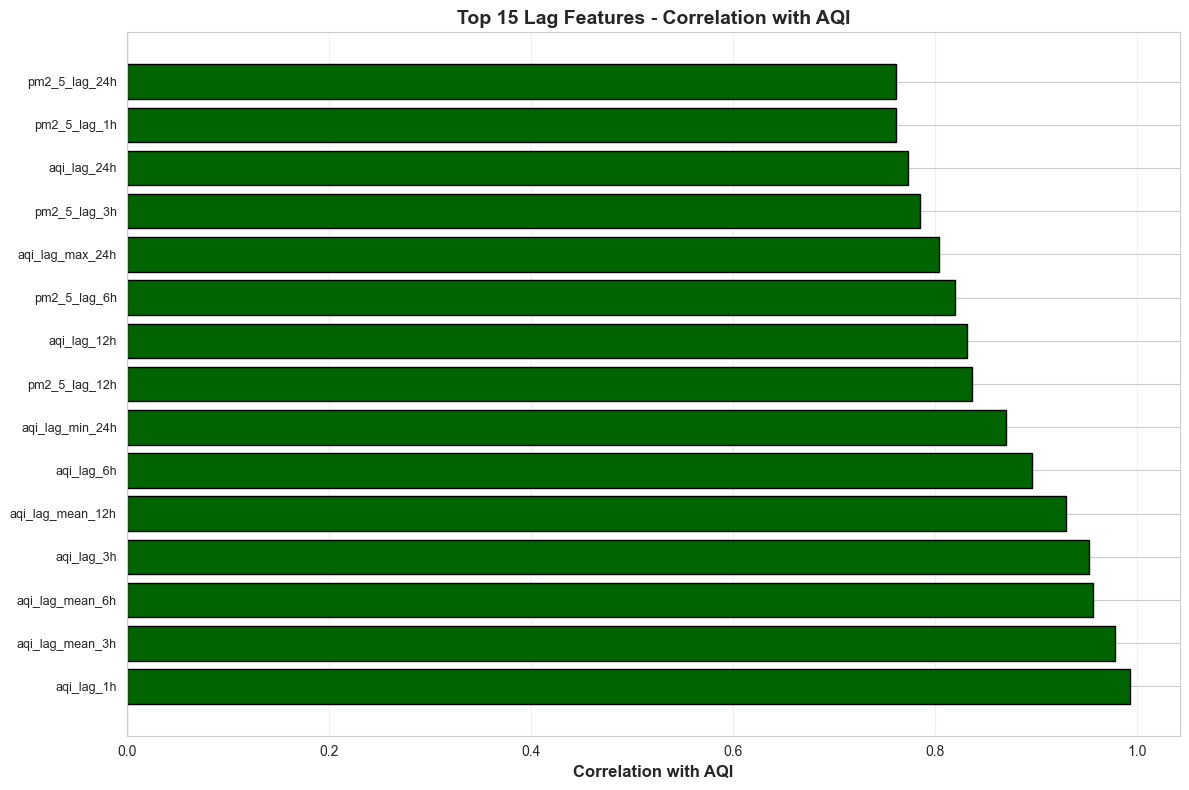


Key Insights:
  • AQI lag features dominate top correlations
  • pm2_5 lag features show strong predictive power
  • carbon_monoxide lags provide moderate correlation
  • Lag features essential for time series prediction


In [22]:
fig, ax = plt.subplots(figsize=(12, 8))
top_15_lag = lag_correlations.head(15)
colors = ['darkgreen' if x > 0.7 else 'green' if x > 0.5 else 'orange' if x > 0.3 else 'gray' for x in top_15_lag.values]
ax.barh(range(len(top_15_lag)), top_15_lag.values, color=colors, edgecolor='black')
ax.set_yticks(range(len(top_15_lag)))
ax.set_yticklabels(top_15_lag.index, fontsize=9)
ax.set_xlabel('Correlation with AQI', fontsize=12, fontweight='bold')
ax.set_title('Top 15 Lag Features - Correlation with AQI', fontsize=14, fontweight='bold')
ax.axvline(x=0, color='black', linewidth=0.8)
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\nKey Insights:")
print(f"  • AQI lag features dominate top correlations")
print(f"  • pm2_5 lag features show strong predictive power")
print(f"  • carbon_monoxide lags provide moderate correlation")
print(f"  • Lag features essential for time series prediction")

## 12. Lag Features Analysis

Lag features created matching production feature_engineering.py:
- **pm2_5 lags**: 1, 3, 6, 12, 24 hours
- **carbon_monoxide lags**: 1, 3, 6, 12, 24 hours  
- **AQI lags**: 1, 3, 6, 12, 24 hours + rolling mean (3h, 6h, 12h) + rolling max/min (24h)
- **Rolling features**: Disabled (prevented overfitting in production)